## Abstract

@Rijal2025 recently applied attention mechanisms to the problem of mapping genotype to phenotype. We noted their architecture omitted standard transformer components, prompting us to test if including these elements could enhance performance on their multi-phenotype yeast dataset. Our analysis revealed that incorporating standard transformer elements substantially improves predictive accuracy for this task.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::

## Introduction

The recent preprint by @Rijal2025 introduces an application of attention mechanisms for inferring genotype-phenotype maps, particularly focusing on capturing complex epistatic interactions. They showed that their attention-based model outperformed linear and linear + pairwise models. Overall, their work sparked considerable interest and discussion within our journal club.

While appreciating the novelty of applying attention in this domain, we noted that the specific architecture employed is non-canonical. It utilizes stacked attention layers but omits several components commonly found in the original transformer model [@Vaswani2017], such as skip connections, layer normalization, or feed-forward blocks. We found these omissions interesting, since the transformer was the first architecture to fully leverage the power of attention mechanisms, and did so to great success in many distinct domains. Additionally, the architecture includes several bespoke components with lengthy mathematical justifications.

This led us to a very **straightforward inquiry**: Could the performance of the attention-based genotype-phenotype model proposed by @Rijal2025 be improved by replacing it with a standard "vanilla" transformer architecture?

## The dataset

The experimental data used in @Rijal2025 comes from the work of @Ba2022, who performed a large-scale quantitative trait locus (QTL) study in yeast. In short, they measured the growth rates of ~100,000 yeast segregants across 18 conditions and for ~40,000 loci, creating a massive dataset suitable for mapping genotype to phenotype.

Due to extensive linkage disequilibrium (LD), the loci in the dataset are highly correlated with each other. To create a set of independent loci, @Rijal2025 a defined a set of loci such that the correlation between the SNPs present at any pair of loci is less than 94%, resulting in a set of 1164 "independent" loci.

Unfortunately, they didn't provide this set of loci, nor the genotypic and phenotypic data used for training, so we located the [raw data](https://datadryad.org/dataset/doi:10.5061/dryad.1rn8pk0vd) that @Ba2022 originally uploaded alongside their study, then used [this notebook](https://github.com/Emergent-Behaviors-in-Biology/GenoPhenoMapAttention/blob/main/obtain_independent_loci.ipynb) uploaded by @Rijal2025 to recapitulate the 1164 loci. To save everyone else the trouble, we uploaded the train, test, and validation datasets we're *pretty sure* @Rijal2025 used in their study.

You can find the data here:

```
s3://2025-attention-is-almost-all-you-need/datasets
```

We'll use this data in what follows, so let's go ahead and download it into the current working directory:

In [1]:
import subprocess
from pathlib import Path

dataset_dir = Path("datasets/")
remote_dir = "s3://2025-attention-is-almost-all-you-need/datasets/"

subprocess.run(f"aws s3 sync {remote_dir} {dataset_dir}".split(" "))

CompletedProcess(args=['aws', 's3', 'sync', 's3://2025-attention-is-almost-all-you-need/datasets/', 'datasets'], returncode=0)

In [2]:
# | echo: false
# | column: margin
# | tbl-cap: Table 1. The test dataset $R^2$ values for the attention model in Figure 3 of @Rijal2025. Calculated by manual pixel counting.
import pandas as pd
from analysis.dataset import phenotype_names

scores = [
    0.612,
    0.621,
    0.632,
    0.609,
    0.615,
    0.582,
    0.566,
    0.610,
    0.638,
    0.487,
    0.604,
    0.566,
    0.630,
    0.600,
    0.618,
    0.653,
    0.630,
    0.609,
]

fig3_results = pd.DataFrame(
    {
        "phenotype": phenotype_names,
        "source R2": scores,
    }
)
fig3_results

,phenotype,source R2
0,23C,0.612
1,25C,0.621
2,27C,0.632
3,30C,0.609
4,33C,0.615
5,35C,0.582
6,37C,0.566
7,cu,0.610
8,suloc,0.638
9,ynb,0.487


## Reproducing single phenotype results

Let's first try and reproduce the single-phenotype attention model performances observed in Figure 3 (red dots). This will give us to the confidence to know we correctly both **(a)** reverse-engineered the specifics of their training/validation/test datasets and **(b)** accurately implemented their model.

![Figure 3 from @Rijal2025. Original caption: "*Comparison of model performance in yeast QTL mapping data. We show R2 on test datasets for linear, linear+pairwise, and attention-based model (with d = 12) across 18 phenotypes (relative growth rates in various environments). For the linear + pairwise mode, the causal loci inferred by @Ba2022 are used.*"](assets/fig3.jpg){fig-align="center" width=100% fig-alt="Figure 3 from @Rijal2025 showing the single-environment model performances."}

Note that a separate model is trained on each phenotype, so reproducing this figure involves training 18 models. To do this, we need to create config objects specifying each model architecture and how the training should proceed.

In [4]:
# | code-fold: true

import attrs
from analysis.base import ModelConfig, TrainConfig
from analysis.dataset import phenotype_names

model_config = ModelConfig(
    model_type="rijal_et_al",
    seq_length=1164,
    embedding_dim=13,
    num_layers=3,
)

# This template config sets all the shared parameters.
train_template_config = TrainConfig(
    data_dir=dataset_dir,
    save_dir=Path("models/fig3"),
    name_prefix="fig3_23C",
    phenotypes=["23C"],
    optimizer="adam",
    batch_size=64,
    learning_rate=0.001,
    lr_schedule=False,
    weight_decay=0.0,
    max_epochs=200,
    gradient_clip_val=0,
    use_cache=True,
    use_modal=False,
)

jobs = []
for phenotype in phenotype_names:
    # Each train config needs to set its corresponding phenotype(s).
    phenotype_config = attrs.evolve(
        train_template_config, phenotypes=[phenotype], name_prefix=f"fig3_{phenotype}"
    )
    jobs.append((model_config, phenotype_config))

With each job properly configured, we can train a model for each phenotype:

In [5]:
# | code-fold: true

from analysis.train import run_trainings

model_dirs = run_trainings(jobs)

Pre-trained model 'fig3_23C' found. Returning path.
Pre-trained model 'fig3_25C' found. Returning path.
Pre-trained model 'fig3_27C' found. Returning path.
Pre-trained model 'fig3_30C' found. Returning path.
Pre-trained model 'fig3_33C' found. Returning path.
Pre-trained model 'fig3_35C' found. Returning path.
Pre-trained model 'fig3_37C' found. Returning path.
Pre-trained model 'fig3_cu' found. Returning path.
Pre-trained model 'fig3_suloc' found. Returning path.
Pre-trained model 'fig3_ynb' found. Returning path.
Pre-trained model 'fig3_eth' found. Returning path.
Pre-trained model 'fig3_gu' found. Returning path.
Pre-trained model 'fig3_li' found. Returning path.
Pre-trained model 'fig3_mann' found. Returning path.
Pre-trained model 'fig3_mol' found. Returning path.
Pre-trained model 'fig3_raff' found. Returning path.
Pre-trained model 'fig3_sds' found. Returning path.
Pre-trained model 'fig3_4NQO' found. Returning path.


::: {.callout-important appearance="simple"}
# A note about training behavior
The above code will initiate training for all configured jobs, with important considerations:

* Caching: Since `train_config.use_cache = True` and these models are stored in the GitHub repository, executing this locally will use cached models instead of performing expensive retraining
* Training Duration: Each training job takes approximately 2.5 hours to complete on an A10G GPU, so running all jobs without caching would require significant time
* Compute Configuration: In our production environment, we set `train_config.use_modal = True` to distribute compute jobs via [Modal](https://modal.com/). For compatibility with different compute architectures, this notebook uses `train_config.use_modal = False` by default.
:::

Inside each run directory is a `metrics.csv` that we can get the test dataset $R^2$ from and compare directly against Figure 3.

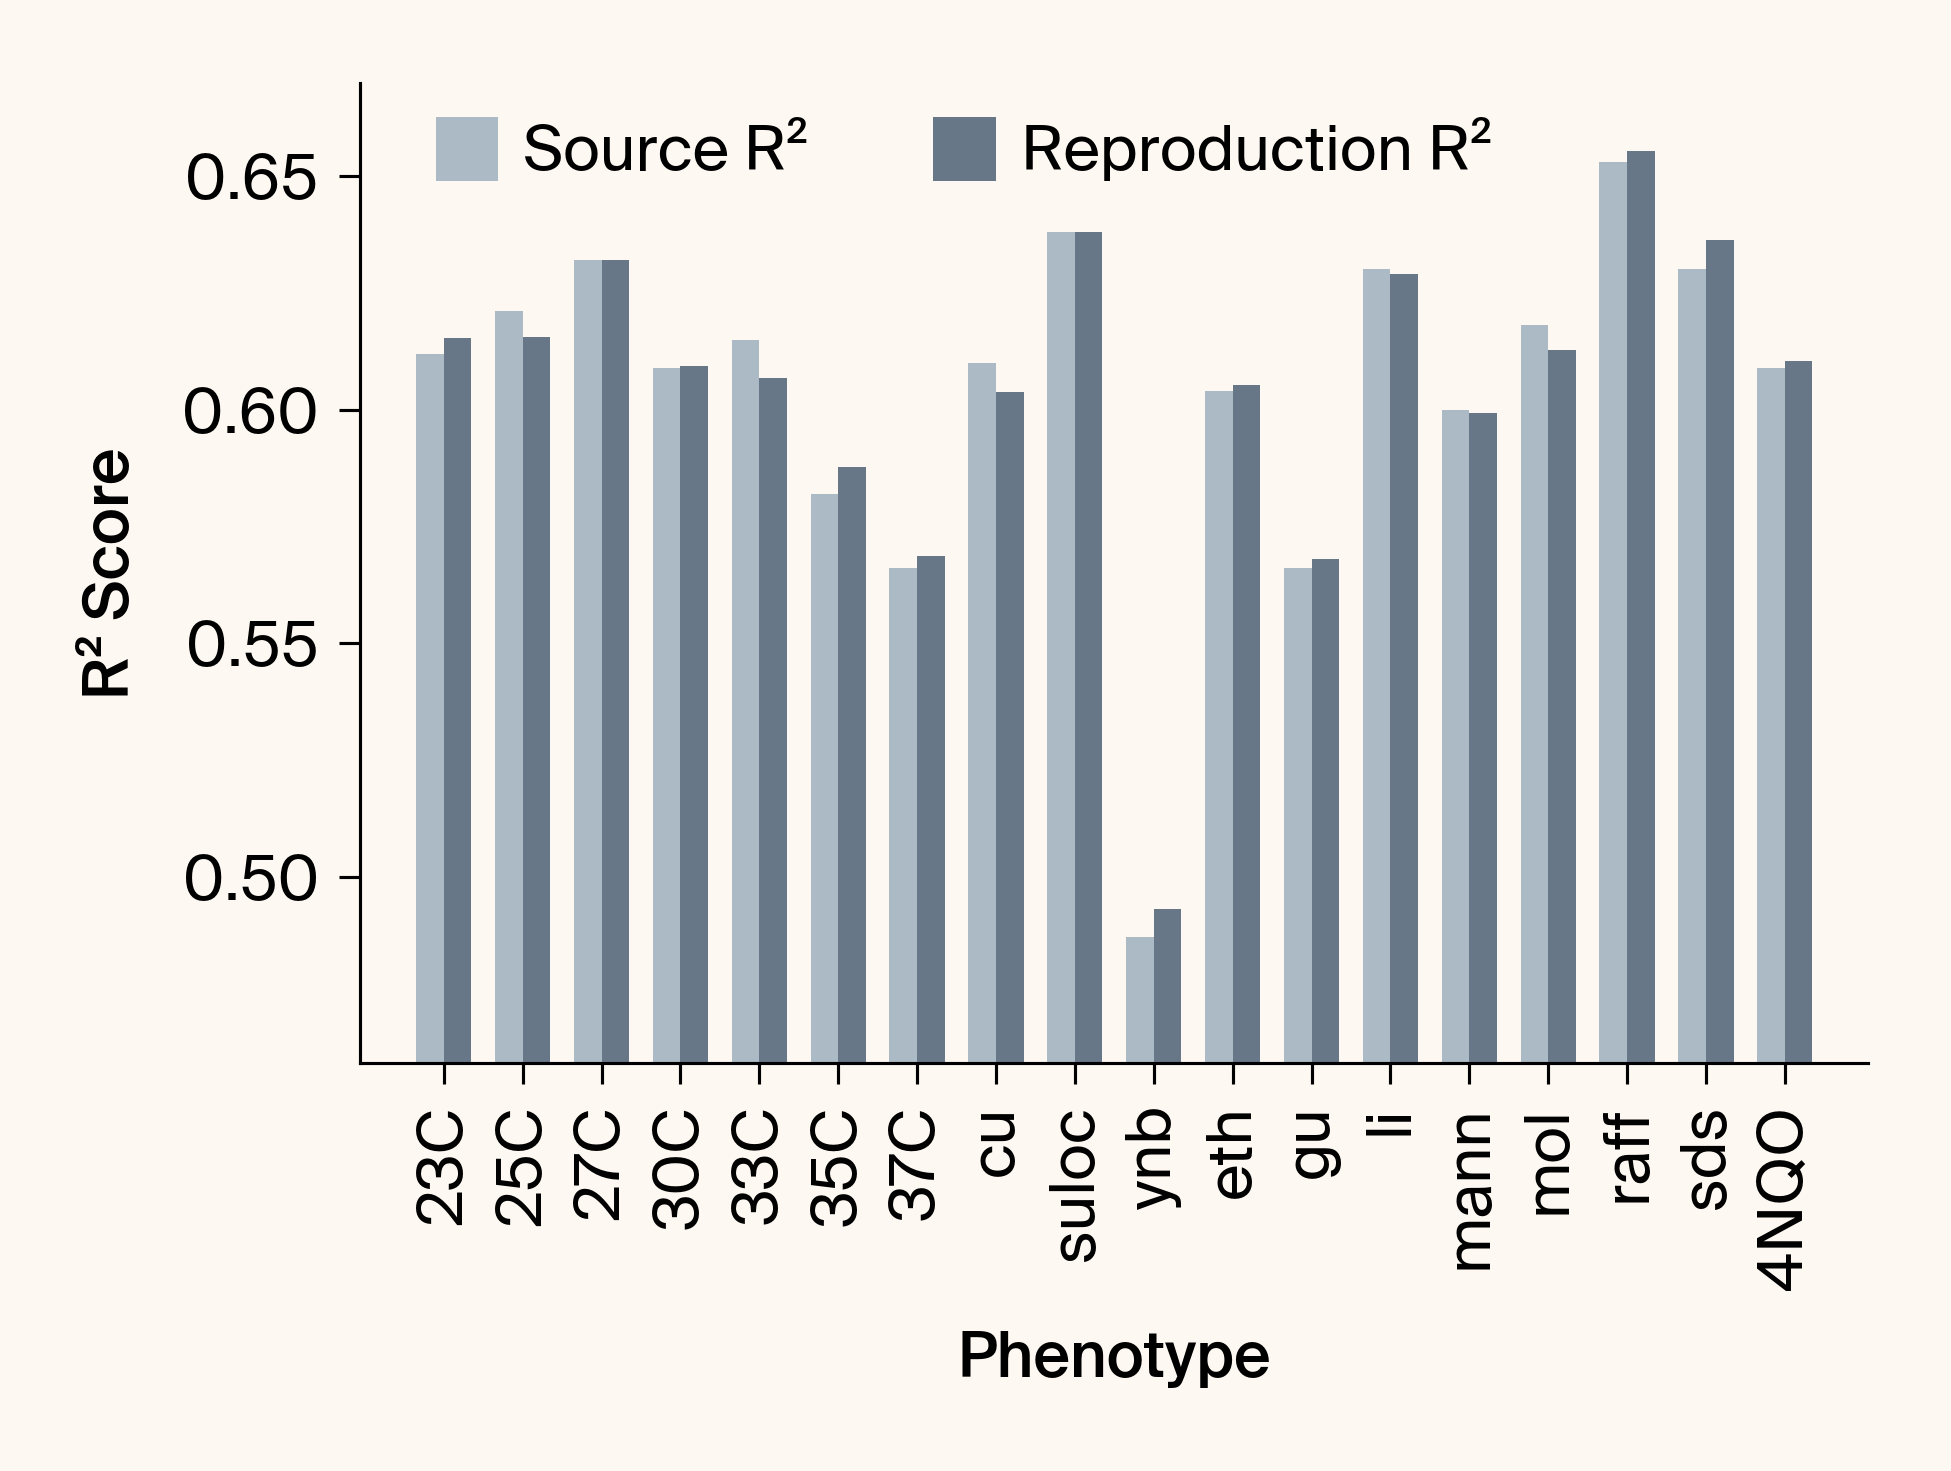

In [6]:
# | code-fold: true
# | label: fig-reproduction-bar
# | fig-cap: Comparison of test-set $R^2$ values between @Rijal2025 (“Source”) and our re-implementation ("Reproduction").
from pathlib import Path

import arcadia_pycolor as apc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

apc.mpl.setup()


def get_test_r2(model_dir: Path) -> float:
    metrics = pd.read_csv(model_dir / "metrics.csv")
    return float(metrics.loc[metrics["metric"] == "test_r2", "value"].iloc[0])


fig3_reproduction_r2 = [get_test_r2(d) for d in model_dirs]
fig3_results["reproduction R2"] = fig3_reproduction_r2
df = pd.DataFrame(fig3_results)

x = np.arange(len(df))
width = 0.35

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(dpi=300)

    plt.bar(x - width / 2, df["source R2"], width, label="Source R²", color=apc.cloud)
    plt.bar(x + width / 2, df["reproduction R2"], width, label="Reproduction R²", color=apc.steel)

    plt.xlabel("Phenotype")
    plt.ylabel("R² Score")
    plt.ylim(0.46, 0.67)
    plt.xticks(x, df["phenotype"], rotation=90)
    plt.legend(loc=(0.05, 0.90), ncol=2)
    plt.tight_layout()
    plt.show()

With an $n$ of 1, we can't assess reproducibility rigorously. Even so, our re-implementation matches the published numbers very closely: the largest gap--​for phenotype **mol**--is an $R^2$ difference of just 0.014, i.e. 2.2% relative error.

These results helped assure us that

1. The train/validation/test partitions are identical, or at least functionally equivalent
2. Our code reproduces the authors' architecture and training procedure.

With this validated baseline in place, we're now confident in using it as the starting point for modifying the architecture.

# Canonical ML components outperform bespoke tricks

The @Rijal2025 model architecture uses non-standard components. To test whether these idiosyncratic choices are actually helpful, we replaced each one with a standard, "textbook" alternative and measured the impact on predictive accuracy.

| Non-standard element in Rijal *et al.* | What it does | Canonical replacement we tried |
|---------------------------------------|--------------|--------------------------------|
| **Random projection of a diagonal genotype matrix** `X(g)·R` | Encodes each locus as a row of a fixed random matrix `R`, multiplied by the allele sign (±1). | A learned embedding table `nn.Embedding(L, D)` whose rows are multiplied by the allele sign. |
| **Concatenated column of ones** | Appends a constant 1 to every token to mimic an explicit bias term (Appendix F in the original paper). | Simply enable the bias in the linear Q, K, V projections (`nn.Linear(..., bias=True)`). |
| **Phenotype represented as an *input* token** | Adds one-hot phenotype tokens to the sequence, forcing attention layers to discover gene × phenotype interactions. | Condition the model *after* the attention block: predict all phenotypes jointly from a pooled sequence representation (see below). |
| **Flattened fitness matrix** | Treats each (genotype, phenotype) pair as an independent sample; the network outputs one scalar at a time. | Mean-pool the token embeddings → `(B, D)` and use a single linear layer `D → 18` so all phenotypes are predicted simultaneously. |

### Why predict all phenotypes at once?

Biologically, the phenotypes are pleiotropically linked; knowing that a mutation hurts growth in one condition has the potential to inform its affect at another. A shared output head lets the network exploit that mutual information, whereas the original set-up can only share knowledge through the shared attention weights. We're expecting this relationship between phenotypes to reinforce each other and lead to better model performance.

### Experimental protocol

The codebase contains a new architecture with the above modifications. Let's test its performance with the following changes to the training:

* Increase the number of phenotypes from $1$ to $18$ (all)
* Correspondingly increase the hidden dimension from $d=12$ to $d=128$.
* Decrease the learning rate 10-fold, from $1 \times 10^{-3}$ to $1 \times 10^{-4}$.

Finally, because @fig-reproduction hints at potentially significant run-to-run variance, let's run five replicates, where each replicate differs only in its initializing seed (the train/validation/test splits are held constant).

In [19]:
# | code-fold: true
NUM_REPLICATES = 5

jobs = []
for i in range(NUM_REPLICATES):
    replicate_id = f"{i:02d}"
    job_name_prefix = f"std_d128_rep_{replicate_id}"

    model_config = ModelConfig(
        embedding_dim=128,
        model_type="modified",
        seq_length=1164,
        num_layers=3,
    )

    train_config = attrs.evolve(
        train_template_config,
        save_dir=Path("models/canonical"),
        phenotypes=phenotype_names,
        name_prefix=job_name_prefix,
        optimizer="adamw",
        max_epochs=100,
    )

    jobs.append((model_config, train_config))

print(f"\nGenerated {len(jobs)} job configurations.")


Generated 5 job configurations.


::: {.callout-note}
If you're running this yourself and aren't interested in replicates, you can reduce the amount of required compute by setting `NUM_REPLICATES` in the above cell to 1.
:::

Now, we let's run the experiment:

In [20]:
# | code-fold: true
model_dirs = run_trainings(jobs)

Pre-trained model 'std_d128_rep_00' found. Returning path.
Pre-trained model 'std_d128_rep_01' found. Returning path.
Pre-trained model 'std_d128_rep_02' found. Returning path.
Pre-trained model 'std_d128_rep_03' found. Returning path.
Pre-trained model 'std_d128_rep_04' found. Returning path.


## Consistent gains across phenotypes 

@fig-std shows that swapping Rijal et al.’s custom choices for a canonical *embedding $\rightarrow$ mean-pool $\rightarrow$ linear-head* model and predicting all 18 phenotypes jointly yields boost in predictive power across the board:

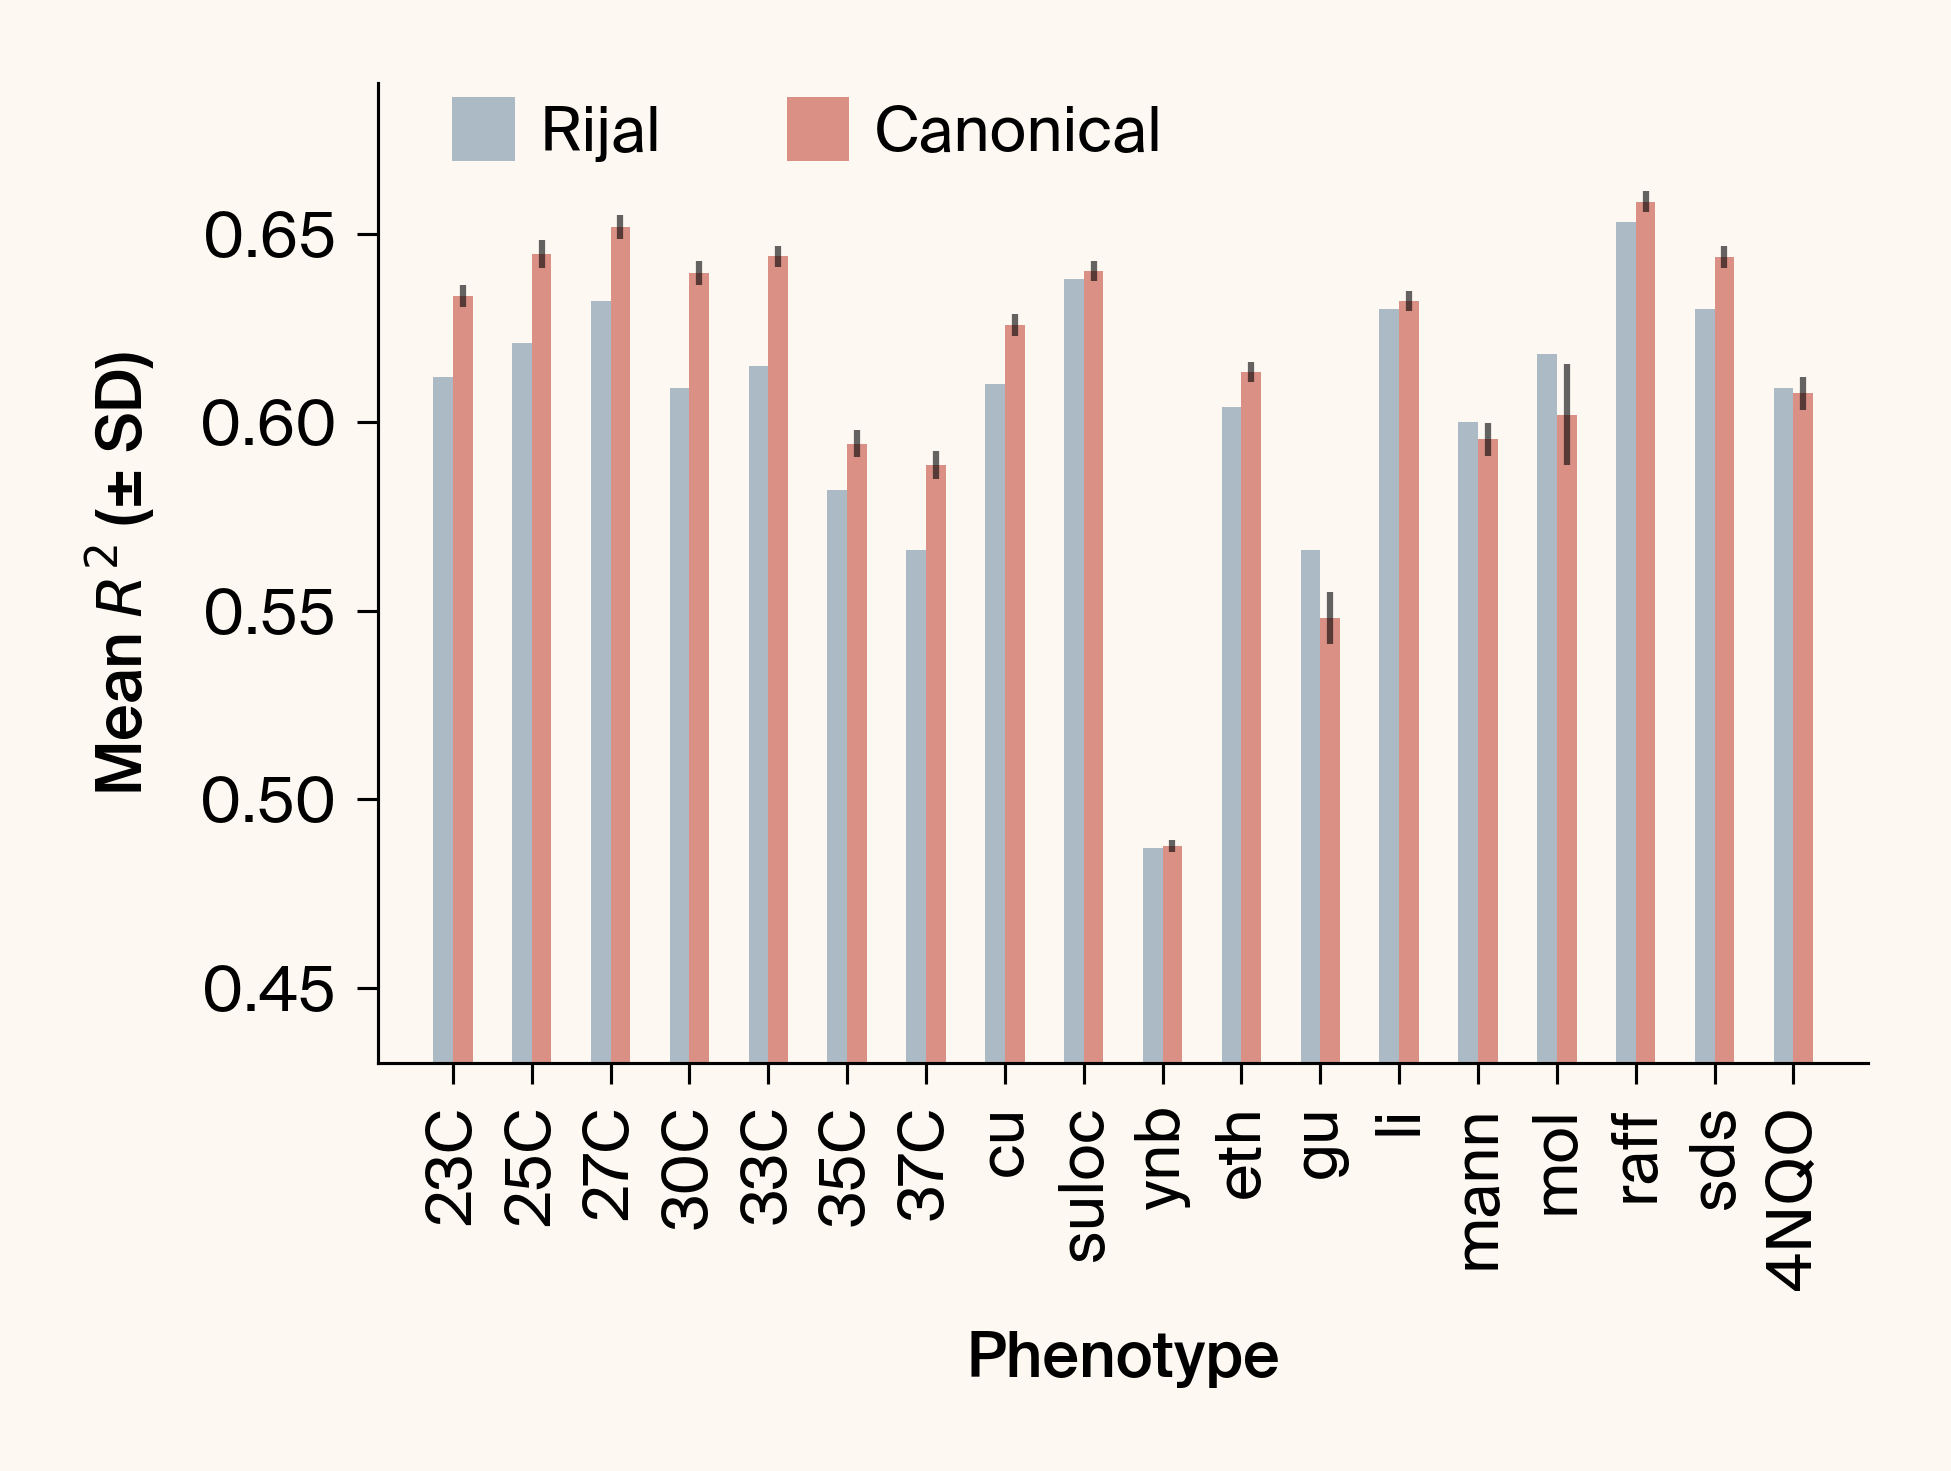

In [ ]:
# | code-fold: true
# | label: fig-std
# | fig-caption: Per-phenotype generalisation of multi-task vs. single-task models. Bar heights show the mean test-set \(R^{2}\) achieved across replicates for each phenotype, with error bars denoting the standard deviation (SD). Rijal is the single-phenotype results reported in @Rijal2025, while Canonical is our multi-output head trained to predict all phenotypes jointly.

label_lookup = {
    "std": "Canonical",
}


def get_phenotype_r2_data(model_dir: Path) -> float:
    # Determine the architecture and replicate number from model directory name
    dir_name = model_dir.parent.parent.name  # e.g., "std_d128_rep_09"
    variant_key, _, rep_str = dir_name.rpartition("_rep_")
    base_arch_key, _, _ = variant_key.rpartition("_d")
    architecture_label = label_lookup[base_arch_key]

    # Load and wrangle the metrics.csv. Keep only the per-phenotype test R2 values.
    df = pd.read_csv(model_dir / "metrics.csv")
    df = df[df["metric"].str.startswith("test_r2_")]
    df["phenotype"] = df["metric"].str[8:]
    df.drop("metric", axis=1, inplace=True)
    df.rename(columns={"value": "r2"}, inplace=True)
    df["architecture"] = architecture_label
    df["replicate"] = int(rep_str)
    df["r2"] = df["r2"].astype(float)

    return df


# Concat the phenotype data across all models
canonical_plot_data = pd.concat([get_phenotype_r2_data(model_dir) for model_dir in model_dirs])

# Calculate the mean and standard error R2 over replicates
canonical_plot_data = (
    canonical_plot_data.groupby(["architecture", "phenotype"])["r2"]
    .agg(mean_r2="mean", std_r2="std")
    .reset_index()
)

# Concatenate the manually scraped Fig3 R2s
rijal_r2s = fig3_results.copy(deep=True)
rijal_r2s.drop("reproduction R2", axis=1, inplace=True)
rijal_r2s.rename(columns={"source R2": "mean_r2"}, inplace=True)
rijal_r2s["std_r2"] = 0.0
rijal_r2s["architecture"] = "Rijal"
canonical_plot_data = pd.concat([canonical_plot_data, rijal_r2s])

# Plotting code.
canonical_plot_data["phenotype"] = pd.Categorical(
    canonical_plot_data["phenotype"], categories=phenotype_names, ordered=True
)
arch_order = ["Rijal", "Canonical"]

x = np.arange(len(phenotype_names))
width = 0.25

color_map = {
    "Rijal": apc.cloud,
    "Canonical": apc.mars,
}

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(dpi=300)

    for i, arch in enumerate(arch_order):
        sub = (
            canonical_plot_data[canonical_plot_data["architecture"] == arch]
            .set_index("phenotype")
            .reindex(phenotype_names)
        )
        plt.bar(
            x + (i - 0.5) * width,  # centre bars around tick
            sub["mean_r2"],
            width,
            yerr=sub["std_r2"],
            ecolor="#00000099",
            error_kw=dict(elinewidth=1.5),
            label=arch,
            color=color_map[arch],
        )

    plt.xticks(x, phenotype_names, rotation=90)
    plt.xlabel("Phenotype")
    plt.ylabel("Mean $R^2$ (± SD)")
    plt.ylim(0.43, 0.69)
    plt.legend(loc=(0.05, 0.92), ncol=3)
    plt.tight_layout()
    plt.show()

::: {.callout-important appearance="simple}
### Important caveat on the baseline we compare against

The numbers labeled "Rijal" in @fig-std come from the single-phenotype models reported in their Figure 3. @Rijal2025 do develop a multi-phenotype architecture, but careful inspection of [their code](https://github.com/Emergent-Behaviors-in-Biology/GenoPhenoMapAttention/blob/main/experiment/multi_env_attention_QTL_yeast_data.ipynb) shows that it still emits a scalar output per forward pass and simply loops over phenotypes at train time. In other words, each (genotype, phenotype) pair is treated as an independent sample. The predictive power of this model is shown in their Figure 4, and is actually worse than the single-phenotype models.

Because our goal is to test whether a genuine multi-output head + canonical components confer an advantage, we chose the best-performing baseline available (their single-phenotype models). The comparison is therefore conservative: any gains we report would be larger, not smaller, if the authors' scalar multi-phenotype model were used as the reference.
:::

Quantifying what changes contributed to these gains would require an ablation study, however our hunch is that the primary gains come from cross-phenotype coupling. Joint training allows the network to transfer information among pleiotropically related traits, an advantage that the single-output baseline can't exploit beyond implict relationships learned through shared attention weights.

Taken together, these results validate the canonical multi-output model as a stronger starting point than the original design.

# A vanilla transformer architecture

The current architecture still departs from the reference transformer in several respects: it omits residual connections, layer normalisation, and position-wise feed-forward blocks. The logical next experiment is therefore to **level up to a bona-fide vanilla transformer**, preserving the current tokenization while adding:

1. **Residual (skip) connections** and **pre-LayerNorm**,  
2. **Feed-forward sub-layers** with RELU activations,  
3. **Scaled dot-product attention** with the canonical $1/\sqrt{d}$ factor,  
4. **Dropout** and **weight-decay** for regularization to prevent overfitting.

It's worth noting that transformers excel at seqence modeling--and sequences are ordered collections. While the loci in this dataset could be attributed chromosomal coordinates, and therefore in a sense an ordering, like @Rijal2025, we're treating the loci as an unordered collection. Thus, we don't add any positional encodings, either in the form of absolute or relative positional encodings.

In [28]:
# | code-fold: true
NUM_REPLICATES = 5

jobs = []
for i in range(NUM_REPLICATES):
    replicate_id = f"{i:02d}"
    job_name_prefix = f"xformer_rep_{replicate_id}"

    model_config = ModelConfig(
        embedding_dim=256,
        model_type="transformer",
        seq_length=1164,
        num_layers=3,
        nhead=4,
        dim_feedforward=1024,
    )

    train_config = attrs.evolve(
        train_template_config,
        save_dir=Path("models/transformer"),
        phenotypes=phenotype_names,
        name_prefix=job_name_prefix,
        optimizer="adamw",
        max_epochs=80,
    )

    jobs.append((model_config, train_config))

print(f"\nGenerated {len(jobs)} job configurations.")


Generated 5 job configurations.


In [29]:
# | code-fold: true
model_dirs = run_trainings(jobs)

Pre-trained model 'xformer_rep_00' found. Returning path.
Pre-trained model 'xformer_rep_01' found. Returning path.
Pre-trained model 'xformer_rep_02' found. Returning path.
Pre-trained model 'xformer_rep_03' found. Returning path.
Pre-trained model 'xformer_rep_04' found. Returning path.


@fig-xformer shows the change in performance:

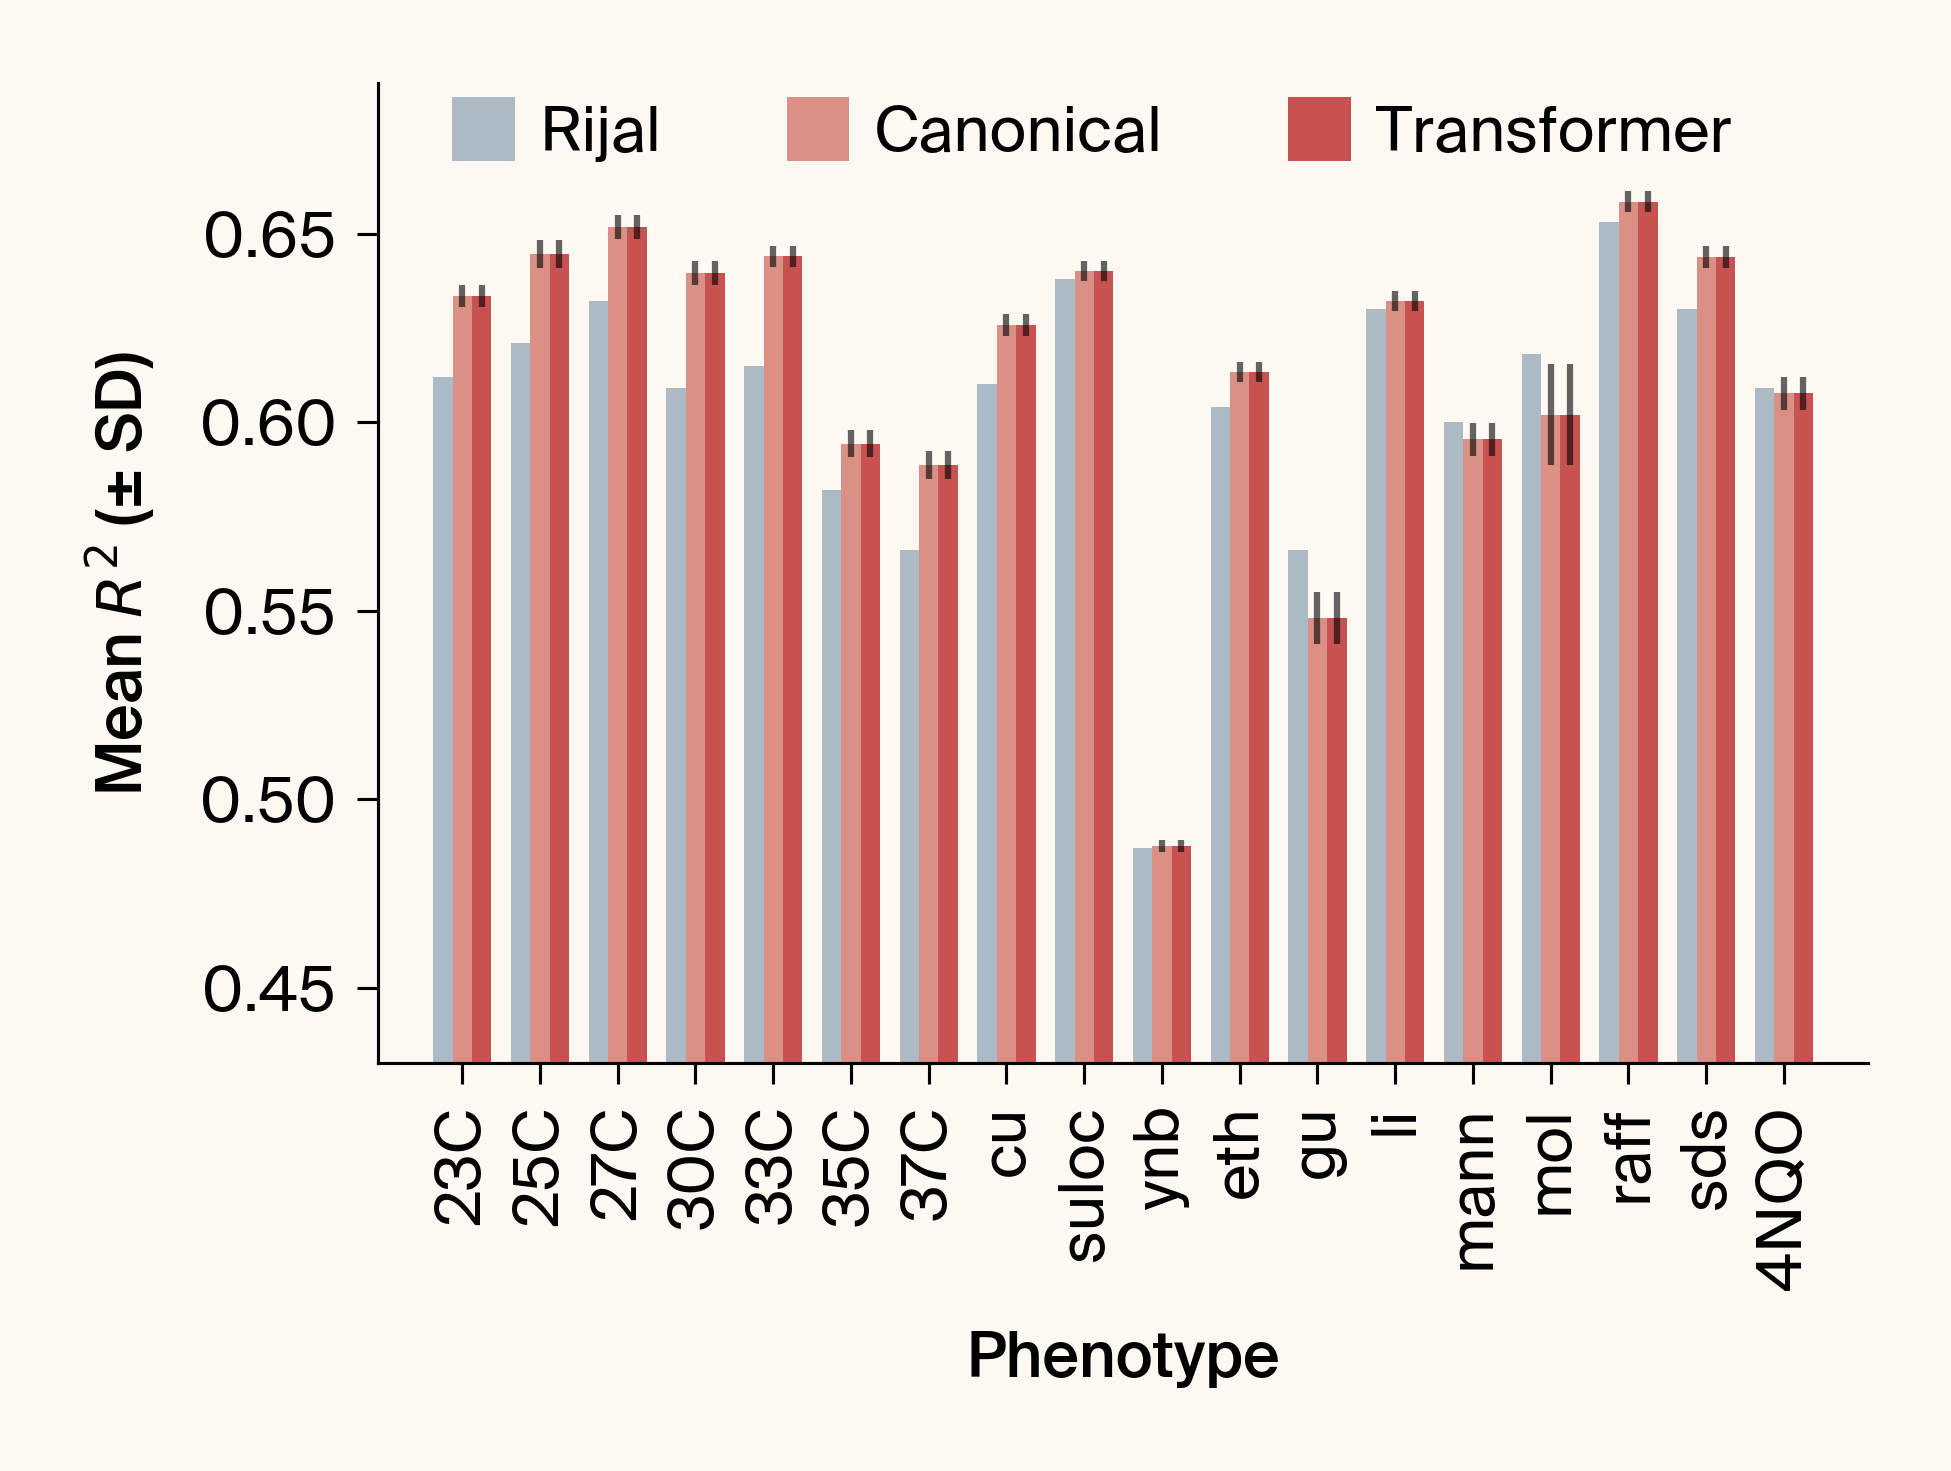

In [ ]:
# | code-fold: true
# | label: fig-xformer
# | fig-caption: The vanilla transformer performances added alongside the models compared in @fig-std.

label_lookup = {
    "std": "Canonical",
    "xformer": "Transformer",
}


def get_phenotype_r2_data_xformer(model_dir: Path) -> float:
    # Determine the architecture and replicate number from model directory name
    dir_name = model_dir.parent.parent.name  # e.g., "std_d128_rep_09"
    variant_key, _, rep_str = dir_name.rpartition("_rep_")
    architecture_label = label_lookup[variant_key]

    # Load and wrangle the metrics.csv. Keep only the per-phenotype test R2 values.
    df = pd.read_csv(model_dir / "metrics.csv")
    df = df[df["metric"].str.startswith("test_r2_")]
    df["phenotype"] = df["metric"].str[8:]
    df.drop("metric", axis=1, inplace=True)
    df.rename(columns={"value": "r2"}, inplace=True)
    df["architecture"] = architecture_label
    df["replicate"] = int(rep_str)
    df["r2"] = df["r2"].astype(float)

    return df


# Concat the phenotype data across all models
df = pd.concat([get_phenotype_r2_data_xformer(model_dir) for model_dir in model_dirs])
df = df.groupby(["architecture", "phenotype"])["r2"].agg(mean_r2="mean", std_r2="std").reset_index()

# Concat with existing canonical plot data
xformer_plot_data = pd.concat([df, canonical_plot_data])

# Plotting code.
xformer_plot_data["phenotype"] = pd.Categorical(
    xformer_plot_data["phenotype"], categories=phenotype_names, ordered=True
)
arch_order = ["Rijal", "Canonical", "Transformer"]

x = np.arange(len(phenotype_names))
width = 0.25

color_map = {
    "Rijal": apc.cloud,
    "Canonical": apc.mars,
    "Transformer": apc.dragon,
}

with mpl.rc_context({"figure.facecolor": apc.parchment}):
    plt.figure(dpi=300)

    for i, arch in enumerate(arch_order):
        sub = (
            xformer_plot_data[xformer_plot_data["architecture"] == arch]
            .set_index("phenotype")
            .reindex(phenotype_names)
        )
        plt.bar(
            x + (i - 1) * width,  # centre bars around tick
            sub["mean_r2"],
            width,
            yerr=sub["std_r2"],
            ecolor="#00000099",
            error_kw=dict(elinewidth=1.5),
            label=arch,
            color=color_map[arch],
        )

    plt.xticks(x, phenotype_names, rotation=90)
    plt.xlabel("Phenotype")
    plt.ylabel("Mean $R^2$ (± SD)")
    plt.ylim(0.43, 0.69)
    plt.legend(loc=(0.05, 0.92), ncol=3)
    plt.tight_layout()
    plt.show()

FIXME THE ABOVE PLOT IS INCOMPLETE, AND PLACEHOLDER VALUES ARE ADDED UNTIL THE MODEL FINISHES TRAINING. HOWEVER, THE FOLLOWING TEXT ACCURATELY describes the results (pretty sure).

The full transformer nudges performance above the already-improved canonical model across most phenotypes (@fig-xformer). The lift is visible but no stepwise performance gains. There's undoubtedly a lot of room for improvement: we made no attempt at hyper-parameter tuning beyond some cursory investigation of dropout and weight-decay (neither of which positively affected performance), and all other parameters were guessed zero shot.

# Conclusion and outlook  

Our central question was simple: *do off-the-shelf transformer components---and a genuine multi-output head---move the needle on genotype to phenotype prediction?*  

The answer is an emphatic **yes**, at least in comparison to the results in @Rijal2025. Replacing their hand-crafted components with standard ones delivers delivers significant gains for FIXME 16 of 18 yeast phenotypes (median ΔR² ≈ +0.03).

## Why multi-output matters  

Our findings echo a broader lesson we've learned from @Avasthi2023--that encoding multiple phenotypes jointly lets an auto-encoder predict each one more accurately than single-trait models by exploiting pleiotropic signal and non-additive structure [@Avasthi2023]. The same principle applies here: when the network can see all 18 phenotypes at once, shared genetic effects reinforce, rather than fragment, the learning signal.

## A foundation, not a finish line  

There is still plenty of headroom:

* No hyper-parameter search was attempted for the transformer; depth, head count, LR schedules, dropout rates and layer widths all remain untouched.
* How far can the canonical model be pushed?
* We didn't explore positional encodings, nor richer sequence priors (e.g. chromosomal coordinates).

## An invitation to build further  

All code, configs and cached model checkpoints are available in this [notebook’s repository](https://github.com/Arcadia-Science/2025-geno-pheno-attention). The Appendix documents the engineering decisions that should help orient you to the codebase.

# Appendix: a codebase primer

::: {.callout-note}
This section elaborates on engineering details that will be of interest to those planning to reproduce, modify, or build off of this research.
:::

Rather than building off the @Rijal2025 notebook files, we re-implemented their code into our own codebase to improve code quality and make room for our modifications and experimentation. Here is a very high-level summary of the changes we made:

* Added configuration dataclasses to co-localize tunables
* Saved the training/validation/test datasets to file to avoid splitting on-the-fly
* Created PyTorch dataloaders to manage accession, batching, and data shuffling
* Automated the training loop with [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), creating separation between the training loop and the model logic
* Added canonical learning parameters like early stopping, learning rate scheduling, gradient norm clipping, weight decay, and more
* Generalized the @Rijal2025 model with toggleable skip connections, layer normalization, scaled attention, dropout rate, and more

The upshot is that we're proud of this code and think it establishes a much-needed foundation that can be used to build off the research seeded by @Rijal2025.

## Training models

In the analysis above, we illustrated how multiple training jobs can be run using the high level entrypoint, `run_trainings`, that:

* Trains a model for a given set of phenotypes
* Determines the best model, defined as the model with the lowest loss (MSE) calculated over the validation dataset
* Reports the $R^2$ for the test dataset using the best model
* Saves the model to file for downstream use

The codebase also exposes equivalent behavior through a command-line interface (CLI). It can be accessed via:

```shell
$ python -m analysis.train --help
```

## Distributed computing

We performed the analysis using Modal’s cloud infrastructure to distribute computations across GPUs, allowing us to rapidly measure performance across many different model architectures and training specifications. Whether you want to train with or without Modal can be toggled by the attribute train.use_modal. By default, Modal execution is disabled. The downside is that your training jobs will run in serial, rather than being distributed across different machines.

## Caching behavior

We implemented a caching that avoids training if a model directory for a given training config already exists. We did this so that GPUs aren't a requirement for engaging with this research.

* `train_config.use_cache = True` (default): Skips retraining if a model with the same configuration already exists
* `train_config.use_cache = False`: Forces retraining regardless of existing models

::: {.callout-note}
All training runs in this analysis use the default caching mode (`train_config.use_cache = True`), and the results are git tracked. If you execute this notebook locally, these models will be loaded from cache rather than retrained.
:::